## Kalman Filters for pricing securities

In [46]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
import os
from math import *
# If you don't have pykalman installed, run this in terminal "conda install -c conda-forge pykalman"

This function read timeseries for a specific stock and indicator in a specific day (intraday data). You guys don't have access to this data but you can get samples from Yahoo Finance. I will join two sample for Amazon Inc and Standard & Poor's and put it in the drive. Make sure to change the file directory

In [47]:
def read_data (wd,date,index="SPY",indicator="impliedV"):
    path = os.path.join(wd,indicator,index,date+"_"+index+"~market__"+indicator+".csv")
    df = pd.read_csv(path)
    return(df)

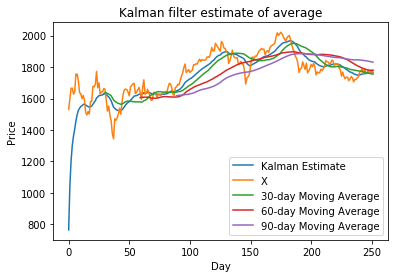

In [59]:
# Load pricing data for a security's volatility
#wd = "/Users/jedhouas/Downloads/ECP"
#date = "20100104"
#x = read_data (wd,date,index="SPY",indicator="impliedV").spot
x = pd.read_csv("/Users/jedhouas/Downloads/AMZN.csv").Close   ### Change here !

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(30).mean()
mean60 = x.rolling(60).mean()
mean90 = x.rolling(90).mean()

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

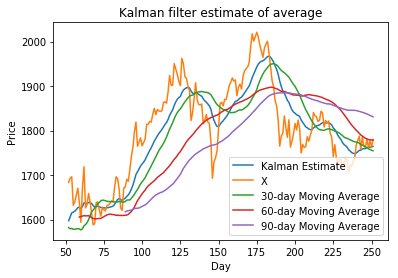

In [60]:
plt.plot(state_means[-200:])
plt.plot(x[-200:])
plt.plot(mean30[-200:])
plt.plot(mean60[-200:])
plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

### Testing Gold vs SPY using Kalman actualization

In [61]:
x = pd.read_csv("/Users/jedhouas/Downloads/SPY.csv").Close # Change here !
y = pd.read_csv("/Users/jedhouas/Downloads/AMZN.csv").Close # Change here !

AttributeError: 'int' object has no attribute 'date'

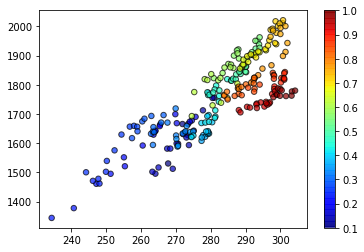

In [62]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('SPY')
plt.ylabel('Gold');

In [63]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [64]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

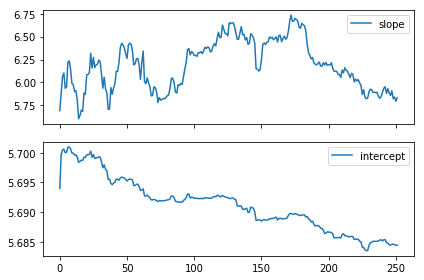

In [65]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

AttributeError: 'int' object has no attribute 'date'

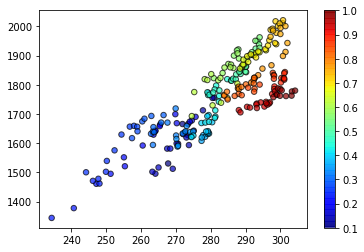

In [66]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([125, 210, 150, 410])

# Label axes
plt.xlabel('SPY')
plt.ylabel('Gold');

AttributeError: 'int' object has no attribute 'date'

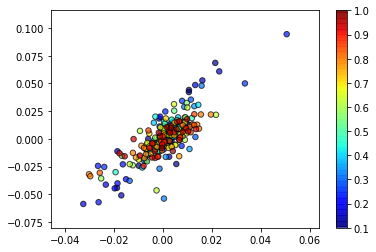

In [67]:
# Get returns from pricing data
x_r = x.pct_change()[1:]
y_r = y.pct_change()[1:]

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-0.03,0.03,-0.11, 0.11])

# Label axes
plt.xlabel('SPY returns')
plt.ylabel('Gold returns');